In [1]:
#load libraries

In [1]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from tqdm import tqdm
from functions import MODEL

from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation, Concatenate, Layer
from tensorflow.keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Embedding, Bidirectional, GlobalMaxPooling1D, LSTM
import tensorflow.keras.backend as K

In [2]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

In [3]:
import tensorflow as tf

In [4]:
from spektral.layers import EdgeConditionedConv, GlobalSumPool,GraphAttention, GlobalAttentionPool

In [5]:
from spektral.utils import label_to_one_hot

In [8]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session

In [6]:
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [9]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = Session(config=config)

In [3]:
#data loader
#npzfile = np.load('final_dti_dataset_maxpad1000.npz')


In [10]:
#print(npzfile.files)

In [11]:
#A,X,E,P,Y = npzfile['A'],npzfile['X'],npzfile['E'],npzfile['P'],npzfile['Y']
#A.shape, X.shape, E.shape, P.shape, Y.shape

In [7]:
#checking the preprocessing as per the spektral tutorial
X_uniq = np.unique(X)

In [10]:
#X_uniq = X_uniq[X_uniq != 0]

In [12]:
#X_uniq

In [14]:
#X_temp = label_to_one_hot(X, X_uniq)

In [13]:
#X_temp.shape

In [14]:
#E_uniq = np.unique(E)
#E_uniq = E_uniq[E_uniq != 0]

In [15]:
#E_uniq

In [16]:
#E_temp = label_to_one_hot(E, E_uniq)

In [17]:
#E_temp.shape

In [27]:
# # Parameters
# N = X_temp.shape[-2]       # Number of nodes in the graphs
# F = X_temp[0].shape[-1]    # Dimension of node features
# S = E_temp[0].shape[-1]    # Dimension of edge features
# n_out = Y.shape[-1]        # Dimension of the target
# max_length = P.shape[1]

In [18]:
# N,F,S,max_length,n_out

In [42]:
#A.shape, X_temp.shape, E_temp.shape, P.shape, Y.shape

In [32]:
try:
  del model, history
except:
  pass

In [33]:
K.clear_session()

In [19]:
# Model Architecture

#Protein branch

P_in = Input(shape=(1000,21))
#emb_target = Embedding(21, 128, input_length=max_length)(P_in) 
conv_target_1 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(P_in)
pool_target_1 = MaxPooling1D(pool_size=2)(conv_target_1)
att_in_target = Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), return_sequences=True, recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(pool_target_1)
#att_out_target = attention()(att_in_target)
flat_1_target = Flatten()(att_in_target)


#Drug branch 

#--- Edge Convolutions

X_in = Input(shape=(123, 17))
A_in = Input(shape=(123, 123))
E_in = Input(shape=(123, 123, 3))

X_1 = EdgeConditionedConv(64, activation='relu')([X_in, A_in, E_in])
X_2 = EdgeConditionedConv(64, activation='relu')([X_1, A_in, E_in])
X_3 = GlobalSumPool()(X_2)

# #--- Graph Attention

# # Model definition
# X_in = Input(shape=(123,17))
# A_in = Input((123, 123))

# gc1 = GraphAttention(64, activation='relu', kernel_regularizer=l2(0.01))([X_in, A_in])
# gc2 = GraphAttention(64, activation='relu', kernel_regularizer=l2(0.01))([gc1, A_in])
# pool = GlobalAttentionPool(128)(gc2)

flat_1_drug = Flatten()(X_3)

concat = Concatenate()([flat_1_target,flat_1_drug])

dense_1 = Dense(128, activation = 'relu',kernel_initializer='glorot_normal')(concat)
dropout = Dropout(0.2)(dense_1)
dense_2 = Dense(32, activation = 'relu',kernel_initializer='glorot_normal')(dropout)

# softmax classifier
y_output = Dense(3, activation='softmax')(dense_2)

#model = Model(inputs=[P_in,X_in, A_in], outputs=y_output) #for GraphAttention networks



model = Model(inputs=[P_in,X_in, A_in, E_in], outputs=y_output) #EdgeConvolution


In [ ]:
# metrics = [
#     keras.metrics.FalseNegatives(name="fn"),
#     keras.metrics.FalsePositives(name="fp"),
#     keras.metrics.TrueNegatives(name="tn"),
#     keras.metrics.TruePositives(name="tp"),
#     keras.metrics.BinaryAccuracy(name='accuracy'),
#     keras.metrics.Precision(name="precision"),
#     keras.metrics.Recall(name="recall"),
#     keras.metrics.AUC(name="auc")
# ]

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000, 21)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 123, 17)]    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 123, 123)]   0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 123, 123, 3) 0                                            
______________________________________________________________________________________________

In [22]:
#plot_model(model,  to_file='model_edgeconv.png', show_shapes=True, show_layer_names=True)

In [37]:
#test train split

#A_train, A_test, X_train, X_test, E_train, E_test, P_train, P_test, Y_train, Y_test = train_test_split(A, X_temp, E_temp, P, Y, test_size=0.1, random_state=0)

In [38]:
#np.savez('final_dti_dataset_train', A_train=A_train, X_train=X_train,E_train=E_train, P_train=P_train, Y_train=Y_train)

In [39]:
#np.savez('final_dti_dataset_test', A_test=A_test, X_test=X_test,E_test=E_test, P_test=P_test, Y_test=Y_test)

In [22]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=5, min_lr=0.00001, verbose=1)
#model_checkpoint = ModelCheckpoint('checkpoint.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
cb_early = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, restore_best_weights=True)

In [18]:
# FIT MODEL
################################################################################
#history  = model.fit([P_train,X_train, A_train, E_train],Y_train,batch_size=8,epochs=50,validation_split=0.1)
#history  = model.fit([P,X,A,E],Y,batch_size=8,epochs=50,validation_split=0.1)
try:
    history  = model.fit([P,X,A,E],Y,batch_size=8,epochs=50,#validation_split=0.1,
    validation_data=([P_t,X_t,A_t,E_t],Y_t), verbose=1, callbacks=[reduce_lr])
except KeyboardInterrupt:
    saved_history = history
    model.save('latest_model.hdf5')
    print('Model saved')


Train on 55461 samples, validate on 6163 samples
Epoch 1/100
55461/55461 [==============================] - 2590s 47ms/sample - loss: 1.0486 - accuracy: 0.5562 - val_loss: 0.8744 - val_accuracy: 0.6046
Epoch 2/100
55461/55461 [==============================] - 2440s 44ms/sample - loss: 0.8267 - accuracy: 0.6234 - val_loss: 0.7899 - val_accuracy: 0.6477
Epoch 3/100
55461/55461 [==============================] - 2475s 45ms/sample - loss: 0.7585 - accuracy: 0.6654 - val_loss: 0.7636 - val_accuracy: 0.6571
Epoch 4/100
55461/55461 [==============================] - 2425s 44ms/sample - loss: 0.7043 - accuracy: 0.6950 - val_loss: 0.7068 - val_accuracy: 0.6969
Epoch 5/100
55461/55461 [==============================] - 2426s 44ms/sample - loss: 0.6608 - accuracy: 0.7182 - val_loss: 0.7046 - val_accuracy: 0.6992
Epoch 6/100
55461/55461 [==============================] - 2443s 44ms/sample - loss: 0.6254 - accuracy: 0.7361 - val_loss: 0.6582 - val_accuracy: 0.7246
Epoch 7/100
55461/55461 [========

In [25]:
del P,X,A,E

In [19]:
model.save('copy_checkpoint.hdf5')

In [20]:
old_history = history

NameError: name 'history' is not defined

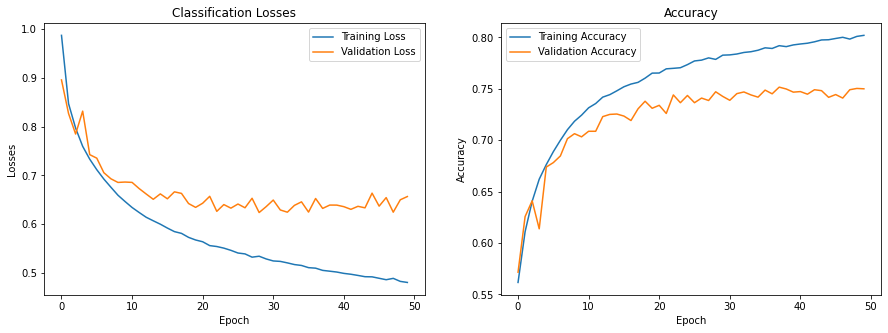

In [20]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(old_history.history['loss'])
plt.plot(old_history.history['val_loss'])
plt.title("Classification Losses")
plt.ylabel("Losses")
plt.xlabel("Epoch")
plt.legend(["Training Loss","Validation Loss"])
plt.subplot(1,2,2)
plt.plot(old_history.history['accuracy'])
plt.plot(old_history.history['val_accuracy'])
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training Accuracy","Validation Accuracy"])
plt.show()

In [39]:
#clear memory
del A,X,E,P,Y

In [40]:
del npzfile

In [23]:
# sending data to yogesh
npzfile = np.load('final_dti_dataset_train.npz')

In [24]:
npzfile.files

['A_train', 'X_train', 'E_train', 'P_train', 'Y_train_']

In [25]:
A,X,E,P,Y = npzfile['A_train'],npzfile['X_train'],npzfile['E_train'],npzfile['P_train'],npzfile['Y_train_']
#A,X,E,P,Y = npzfile['A_test'],npzfile['X_test'],npzfile['E_test'],npzfile['P_test'],npzfile['Y_test']
A.shape, X.shape, E.shape, P.shape, Y.shape

((55461, 123, 123),
 (55461, 123, 17),
 (55461, 123, 123, 3),
 (55461, 1000, 21),
 (55461, 3))

In [12]:
#test train split

#A_train, A_test, X_train, X_test, E_train, E_test, P_train, P_test, Y_train, Y_test = train_test_split(A, X, E, P, Y, test_size=0.95, random_state=0)

#test train split

#A_train, A_test, X_train, X_test, E_train, E_test, P_train, P_test, Y_train, Y_test = train_test_split(A, X, E, P, Y, test_size=0.1, random_state=0)

In [9]:
#A_train.shape, A_test.shape, X_train.shape, X_test.shape, E_train.shape, E_test.shape, P_train.shape, P_test.shape, Y_train.shape, Y_test.shape

In [8]:
#np.savez('final_dti_dataset_tiny', A=A_train, X=X_train,E=E_train, P=P_train, Y=Y_train)

In [26]:
# load test data and validate

In [16]:
npzfile_t = np.load('final_dti_dataset_test.npz')

In [17]:
#A,X,E,P,Y = npzfile['A_train'],npzfile['X_train'],npzfile['E_train'],npzfile['P_train'],npzfile['Y_train_']
A_t,X_t,E_t,P_t,Y_t = npzfile_t['A_test'],npzfile_t['X_test'],npzfile_t['E_test'],npzfile_t['P_test'],npzfile_t['Y_test']
A_t.shape, X_t.shape, E_t.shape, P_t.shape, Y_t.shape

((6163, 123, 123),
 (6163, 123, 17),
 (6163, 123, 123, 3),
 (6163, 1000, 21),
 (6163, 3))

In [21]:
Y_test_pred = model.predict([P_t,X_t,A_t,E_t],batch_size=8)

In [22]:
Y_test_pred.shape

(6163, 3)

In [25]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(Y_t[:, i], Y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

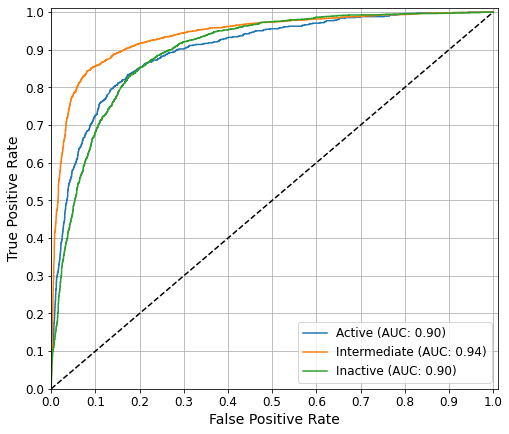

In [26]:
# Plot of a ROC curve for a specific class
fig, ax = plt.subplots(figsize=(8,7))
for i, activity in zip(range(3),['Active', 'Intermediate','Inactive']):
    ax.plot(fpr[i], tpr[i], label=activity+' (AUC: %0.2f)' % roc_auc[i], alpha=1)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_ylim([0.0, 1.01])
ax.set_xlim([0.0, 1.01])
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
#ax.set_title('Receiver operating characteristic ('+train_test+')', fontsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12) 
#ax.text(0.035, 0.925, 'Average AUC:'+str(np.round(np.mean(roc_auc),3)))
ax.grid()
ax.legend(fontsize=12)
plt.savefig('roc.png', dpi=500, bbox_inches='tight')

In [27]:
precision = dict()
recall = dict()
average_precision = dict()
#y_pred_keras = model.predict(X)[0]
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(Y_t[:, i], Y_test_pred[:, i])
    average_precision[i] = average_precision_score(Y_t[:, i], Y_test_pred[:, i])

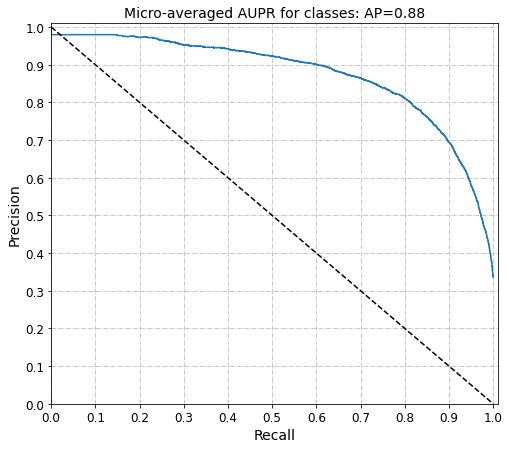

In [31]:
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_t.ravel(), Y_test_pred.ravel())
average_precision["micro"] = average_precision_score(Y_t, Y_test_pred, average="micro")
#print('Average precision score , micro-averaged over all classes: {0:0.2f}'
#    .format(average_precision["micro"]))

fig, ax = plt.subplots(figsize=(8,7))
ax.step(recall['micro'], precision['micro'], where='post')

ax.set_xlabel('Recall', fontsize=14)
ax.set_ylabel('Precision', fontsize=14)
ax.plot([0, 1], [1, 0], 'k--')
ax.set_ylim([0.0, 1.01])
ax.set_xlim([0.0, 1.01])
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_title(
    'Micro-averaged AUPR for classes: AP={0:0.2f}'
    .format(average_precision["micro"]), fontsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12) 
ax.grid(linestyle='-.', linewidth=0.7)
plt.savefig('aupr.png', dpi=500, bbox_inches='tight')

In [29]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate([P_t,X_t,A_t,E_t], Y_t, batch_size=8)
print("test loss, test acc:", results)

Evaluate on test data
6163/6163 [==============================] - 100s 16ms/sample - loss: 0.8709 - accuracy: 0.8056
test loss, test acc: [0.8708996419322925, 0.8056142]
